## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [1]:
from data_loading import real_data_loading
from data_loading import real_data_processing
from data_loading import label_data

In [2]:
# --- Data loading ---
data_name = "AAPL"
seq_len = 60
start_date = "2005-01-01"
end_date = "2024-11-10"

ori_data = real_data_loading(data_name, start_date, end_date)

print(f"{data_name} dataset is ready. Number of sequences: {len(ori_data)}")

AAPL dataset is ready. Number of sequences: 4979


In [3]:
print(ori_data.head())

all_names = ori_data.columns.get_level_values(0)
feature_names= all_names.tolist()
print(feature_names)

Price      Adj Close     Close      High       Low      Open      Volume  \
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL        AAPL   
Date                                                                       
2005-01-31  1.154273  1.373214  1.390893  1.330536  1.331786  1681097600   
2005-02-01  1.163730  1.384464  1.388750  1.367500  1.375893   678395200   
2005-02-02  1.195251  1.421964  1.426964  1.387321  1.391964  1020062400   
2005-02-03  1.167933  1.389464  1.418393  1.380893  1.412500   731651200   
2005-02-04  1.183393  1.407857  1.409464  1.384464  1.390536   563556000   

Price      Log_Return       ATR       BBW      MACD MACD_Signal        RSI  
Ticker                                                                      
Date                                                                        
2005-01-31   0.038711  0.043237  0.214918  0.047071    0.036300  88.590696  
2005-02-01   0.008159  0.040306  0.222039  0.051872    0.039414  89.490280  
2005-0

In [4]:
# --- Data Processing ---
ori_data = real_data_processing(ori_data, seq_len)
print(len(ori_data))
print(ori_data[0].shape)

4919
(60, 12)



Step 1: Calculating metrics for 4919 windows...
Metric calculation complete.

Step 2: Applying two-stage labeling...
  - Crisis MDD Threshold (90.0th percentile): 0.2750
  - Volatile Vol Threshold (85.0th percentile of non-crisis): 0.0248
Labeling complete.

--- Labeling Results ---
Final Label Distribution:
label
Normal      76.5%
Volatile    13.5%
Crisis      10.0%
Name: proportion, dtype: object

Step 3: Creating final one-hot encoded list...
Finished. 'ori_data_s' is a list of length 4919.

Example 'ori_data' item shape: (60, 12)
Example 'ori_data_s' item: [0.0, 1.0, 0.0]

Example 'ori_data' item (another): (60, 12)
Example 'ori_data_s' item (another): [0.0, 0.0, 1.0]

Total length of 'ori_data': 4919
Total length of 'ori_data_s': 4919

Generating visualization of labeled clusters...
Saved cluster visualization to 'market_regime_clusters.png'


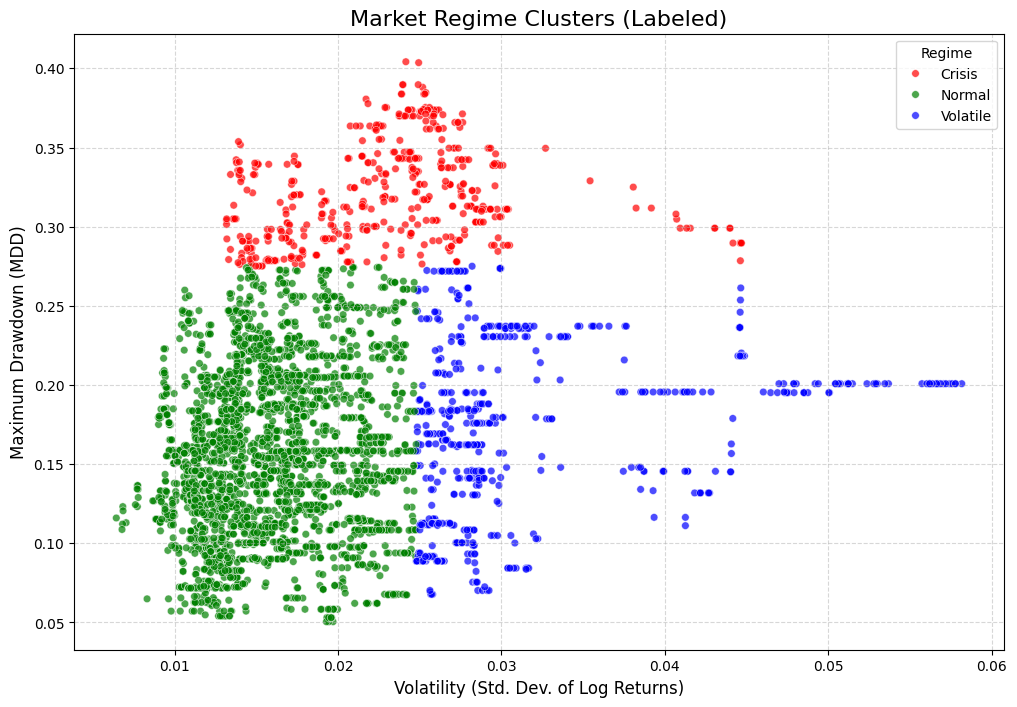

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#########################################################################
# --- MAIN EXECUTION ---
#########################################################################

# Your feature names in the correct order
feature_names = [
    'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
    'Log_Return', 'ATR', 'BBW', 'MACD', 'MACD_Signal', 'RSI'
]

# Run the labeling function
# 'ori_data' is the list you created in your previous code
ori_data_s, metrics_df = label_data(ori_data, feature_names)

# --- Check the results ---
if ori_data_s:
    print(f"\nExample 'ori_data' item shape: {ori_data[0].shape}")
    print(f"Example 'ori_data_s' item: {ori_data_s[0]}")

    print(f"\nExample 'ori_data' item (another): {ori_data[-1].shape}")
    print(f"Example 'ori_data_s' item (another): {ori_data_s[-1]}")

    print(f"\nTotal length of 'ori_data': {len(ori_data)}")
    print(f"Total length of 'ori_data_s': {len(ori_data_s)}")

    # --- Optional Visualization ---
    # This plot helps you confirm the labels make sense
    print("\nGenerating visualization of labeled clusters...")
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=metrics_df,
        x='volatility',
        y='mdd',
        hue='label',
        palette={'Normal': 'g', 'Volatile': 'b', 'Crisis': 'r'},
        alpha=0.7,
        s=30
    )
    plt.title('Market Regime Clusters (Labeled)', fontsize=16)
    plt.xlabel('Volatility (Std. Dev. of Log Returns)', fontsize=12)
    plt.ylabel('Maximum Drawdown (MDD)', fontsize=12)
    plt.legend(title='Regime')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig("market_regime_clusters.png")
    print("Saved cluster visualization to 'market_regime_clusters.png'")

In [ ]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [ ]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'gru'
parameters['hidden_dim'] = 24
parameters['num_layer'] = 3
parameters['iterations'] = 22
parameters['batch_size'] = 128

## Run TimeGAN for synthetic time-series data generation

TimeGAN uses the original data and network parameters to return the generated synthetic data.

In [ ]:
# Run TimeGAN
generated_data = timegan(ori_data, parameters)
print('Finish Synthetic Data Generation')

## Evaluate the generated data

### 1. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

- metric_iteration: the number of iterations for metric computation.

In [ ]:
metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
  temp_disc = discriminative_score_metrics(ori_data, generated_data)
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

## Evaluate the generated data

### 2. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [ ]:
predictive_score = list()
for tt in range(metric_iteration):
  temp_pred = predictive_score_metrics(ori_data, generated_data)
  predictive_score.append(temp_pred)

print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

## Evaluate the generated data

### 3. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

In [ ]:
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')